In [2]:
import sys
import os

# Add the root directory to the Python environment
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
compare_algo = 'bf'


In [25]:
df = pd.read_csv("../data/aggregated/aggregated_1752099016.csv.gz", compression="gzip")
df.head()

,coin,err,algo_time,algo,block,prep_time,n_nodes,n_edges,top_coin_count,avg_time,is_timeout,is_failed
0,0xc944e90c64b2c07662a292be6244bdf05cda44a7,exception: Negative cycle detected.,0.737254,bf,22820266,0.000001,1000,4414,1000,0.737254,False,True
1,0x9e9fbde7c7a83c43913bddc8779158f1368f0413,exception: Negative cycle detected.,0.720065,bf,22820266,0.000001,1000,4414,1000,NaN,False,True
2,0xfdd070e34cbd0923d307f3af481be5bddac4f487,exception: Negative cycle detected.,0.741767,bf,22820266,0.000001,1000,4414,1000,NaN,False,True
3,0xfe0c30065b384f05761f15d0cc899d4f9f9cc0eb,exception: Negative cycle detected.,0.735582,bf,22820266,0.000001,1000,4414,1000,NaN,False,True
4,0x990f341946a3fdb507ae7e52d17851b87168017c,exception: Negative cycle detected.,0.891082,bf,22820266,0.000001,1000,4414,1000,NaN,False,True


In [26]:
# Filter out rows where is_timeout or is_failed is True
# filtered_df = df[(df['is_timeout'] == False) & (df['is_failed'] == False)]
filtered_df = df[(df['is_timeout'] == False)]

# Keep only rows where algo is 'ours' or compare_algo
filtered_df = filtered_df[filtered_df['algo'].isin(['ours', compare_algo])]

# Pivot so that for each coin/block, we keep only those that have both 'ours' and compare_algo responses
pivoted = filtered_df.pivot_table(
    index=['coin', 'top_coin_count'],
    columns='algo',
    values='avg_time'
)

# Drop rows where either 'ours' or compare_algo is missing (i.e., keep only coins/blocks with both responses)
pivoted = pivoted.dropna(subset=['ours', compare_algo])

pivoted.head()


,algo,bf,ours
coin,top_coin_count,,
0x0000000000c5dc95539589fbd24be07c6c14eca4,1000,0.756020,0.002538
0x0000000042156d92b07fe81612746072f18a1fb8,1000,0.677605,0.001868
0x00000000a15fe6875e700d7c1ebbca2367219955,1000,0.675949,0.001819
0x00000000e88649dd6aab90088ca25d772d4607d0,1000,0.656062,0.001798
0x00000000efe302beaa2b3e6e1b18d08d69a9012a,1000,0.679918,0.002119


In [27]:
pivoted.reset_index().top_coin_count.unique()

array([  1000,    100,  10000, 100000])

In [28]:
# Calculate average runtime of 'ours' algo for each top_coin_count
avg_ours_runtime_by_top_coin_count = pivoted.reset_index().groupby('top_coin_count')['ours'].mean()
print("Average runtime of 'ours' algo by top_coin_count:")
print(avg_ours_runtime_by_top_coin_count)


Average runtime of 'ours' algo by top_coin_count:
top_coin_count
100       0.000246
1000      0.002183
10000     0.019264
100000    0.232353
Name: ours, dtype: float64


Relative difference statistics (bf / ours):
347.7205448115662


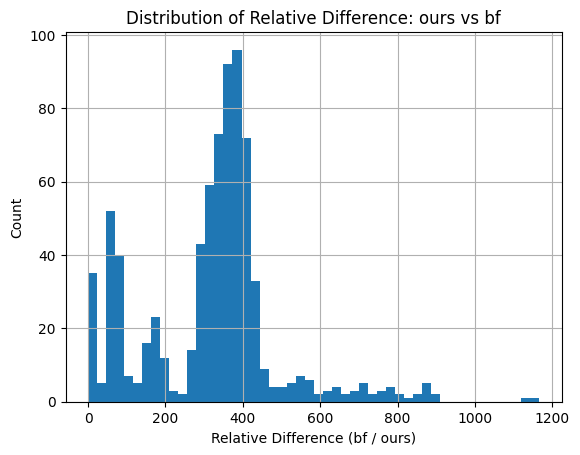

In [29]:
# Calculate how much faster 'ours' algo is compared to compare_algo using the formula:
# (ours_time - mmbf_time) / mmbf_time

pivoted['relative_diff'] = (pivoted[compare_algo]/ pivoted['ours'])

pivoted.to_csv(f"../data/compare/pivoted_{compare_algo}.csv")


print(f"Relative difference statistics ({compare_algo} / ours):")
print(pivoted['relative_diff'].median())

# Optionally, show a histogram
pivoted['relative_diff'].hist(bins=50)
plt.xlabel(f"Relative Difference ({compare_algo} / ours)")
plt.ylabel('Count')
plt.title(f'Distribution of Relative Difference: ours vs {compare_algo}')
plt.show()

